In [1]:


%pip uninstall -y tensorflow keras-tuner
%pip install tensorflow keras-tuner


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


Note: you may need to restart the kernel to use updated packages.


Found existing installation: keras-tuner 1.4.7
Uninstalling keras-tuner-1.4.7:
  Successfully uninstalled keras-tuner-1.4.7
Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl (376.0 MB)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
df = pd.read_csv("D:\\MapApp\\Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.isnull().sum()


CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.shape

(10000, 11)

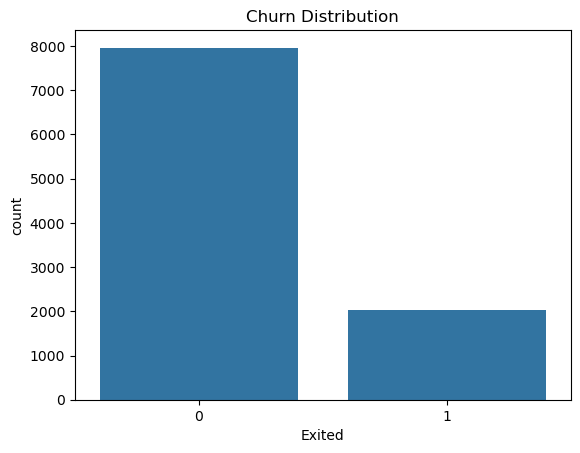

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution')
plt.show()


In [7]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Geography'] = le.fit_transform(df['Geography'])
df['Exited'] = le.fit_transform(df['Exited'])

In [8]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [9]:
# numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','IsActiveMember']
# for feature in numerical_features:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x=df[feature])
#     plt.title(f'Box Plot of {feature}')
#     plt.show()

In [10]:
# for feature in numerical_features:
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

In [11]:
# numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','IsActiveMember']
# for feature in numerical_features:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x=df[feature])
#     plt.title(f'Box Plot of {feature}')
#     plt.show()

In [12]:



X = df.drop("Exited", axis=1)
y = df["Exited"]

# Encode categorical columns
# 1) Gender (Label Encoding: Male=1, Female=0)
labelencoder_gender = LabelEncoder()
X["Gender"] = labelencoder_gender.fit_transform(X["Gender"])

# 2) Geography (One-Hot Encoding)
ct = ColumnTransformer(
    [("geo_encoder", OneHotEncoder(drop="first"), ["Geography"])],
    remainder="passthrough"
)
X = ct.fit_transform(X)

# Convert X to DataFrame if needed
X = pd.DataFrame(X)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)


In [13]:
# Reshape
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Train shape:", X_train_cnn.shape)  
print("Test shape :", X_test_cnn.shape)   


Train shape: (8000, 11, 1)
Test shape : (2000, 11, 1)


In [14]:
unique_classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

class_weights_dict = dict(zip(unique_classes, weights))
print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: 0.628140703517588, 1: 2.450980392156863}


In [15]:
# Define your model
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', 
                 input_shape=(X_train_cnn.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))



model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(1, activation='sigmoid'))

# Add built-in metrics for monitoring
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()


C:\Users\chand\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,977 (35.07 KB)

 Trainable params: 8,977 (35.07 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',   # or 'val_accuracy'
    patience=5,           # number of epochs to wait before stopping
    restore_best_weights=True
)


In [17]:
# Convert y_train, y_test to NumPy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

history = model.fit(
    X_train_cnn, y_train,
    epochs=35,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6652 - loss: 0.6018 - precision: 0.3401 - recall: 0.6843 - val_accuracy: 0.8135 - val_loss: 0.4982 - val_precision: 0.5301 - val_recall: 0.6963
Epoch 2/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7296 - loss: 0.5398 - precision: 0.4023 - recall: 0.7105 - val_accuracy: 0.7855 - val_loss: 0.4691 - val_precision: 0.4805 - val_recall: 0.7309
Epoch 3/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7525 - loss: 0.5335 - precision: 0.4338 - recall: 0.7117 - val_accuracy: 0.8000 - val_loss: 0.4543 - val_precision: 0.5044 - val_recall: 0.7086
Epoch 4/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7685 - loss: 0.5197 - precision: 0.4569 - recall: 0.7187 - val_accuracy: 0.8110 - val_loss: 0.4318 - val_precision: 0.5263 - val_recall: 0.6667
Epoch 5/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7761 - loss: 0.5073 - precision: 0.4723 - recall: 0.7281 - val_accuracy: 0.7960 - val_loss: 0.

In [18]:
loss, accuracy, precision, recall = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final Test Precision: {precision:.4f}")
print(f"Final Test Recall: {recall:.4f}")
print(f"Final Test F1 Score: {2 * (precision * recall) / (precision + recall):.4f}")

Final Test Loss: 0.4318
Final Test Accuracy: 0.8110
Final Test Precision: 0.5263
Final Test Recall: 0.6667
Final Test F1 Score: 0.5882


In [19]:
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Confusion Matrix:
[[1352  243]
 [ 135  270]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9092    0.8476    0.8774      1595
           1     0.5263    0.6667    0.5882       405

    accuracy                         0.8110      2000
   macro avg     0.7178    0.7572    0.7328      2000
weighted avg     0.8317    0.8110    0.8188      2000



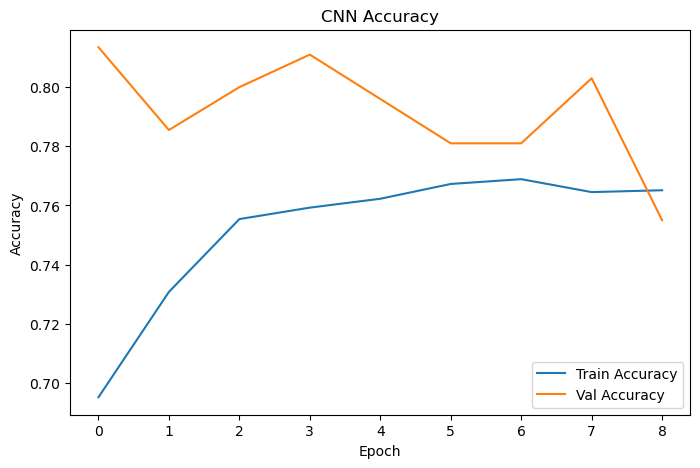

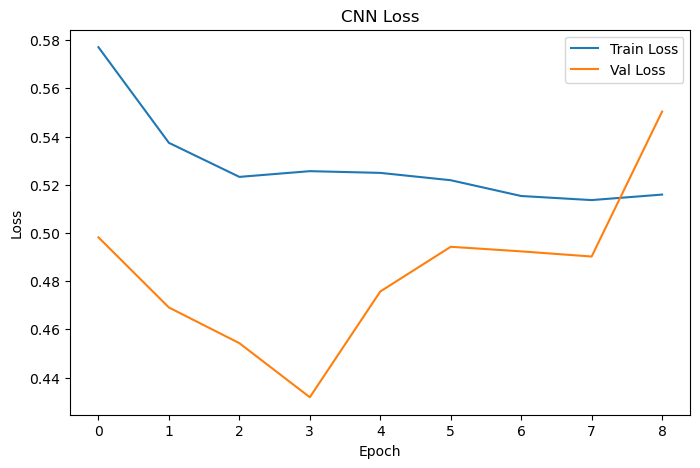

In [20]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [21]:
import numpy as np

train_precision = history.history['precision']
train_recall = history.history['recall']
train_accuracy = history.history['accuracy']

val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_accuracy = history.history['val_accuracy']

# Compute F1 for training
train_f1 = []
for p, r in zip(train_precision, train_recall):
    if (p + r) == 0:
        train_f1.append(0)
    else:
        train_f1.append(2 * p * r / (p + r))

# Compute F1 for validation
val_f1 = []
for p, r in zip(val_precision, val_recall):
    if (p + r) == 0:
        val_f1.append(0)
    else:
        val_f1.append(2 * p * r / (p + r))


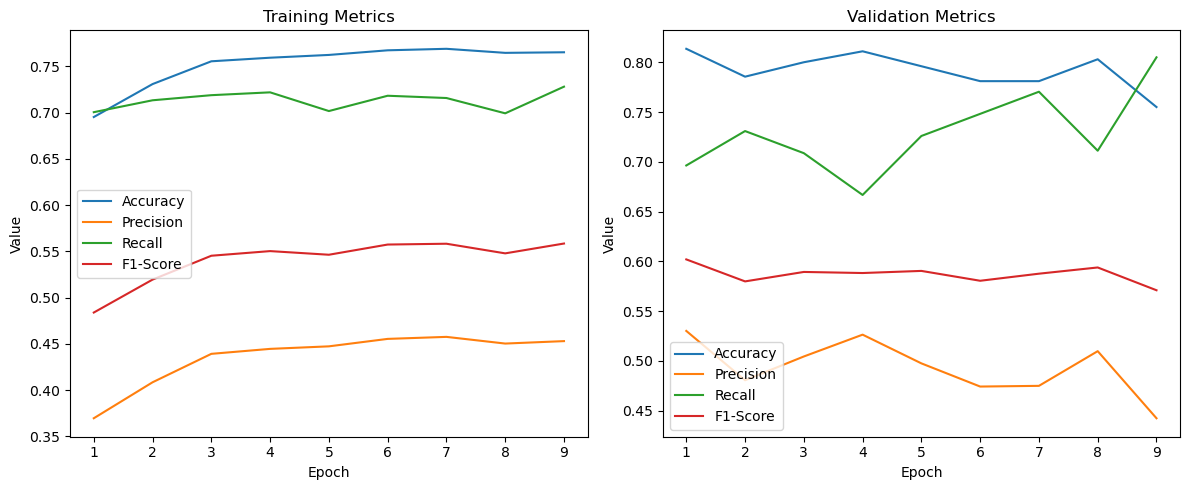

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracy) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# === Training Metrics ===
ax[0].plot(epochs, train_accuracy, label='Accuracy')
ax[0].plot(epochs, train_precision, label='Precision')
ax[0].plot(epochs, train_recall, label='Recall')
ax[0].plot(epochs, train_f1, label='F1-Score')
ax[0].set_title('Training Metrics')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].legend()

# === Validation Metrics ===
ax[1].plot(epochs, val_accuracy, label='Accuracy')
ax[1].plot(epochs, val_precision, label='Precision')
ax[1].plot(epochs, val_recall, label='Recall')
ax[1].plot(epochs, val_f1, label='F1-Score')
ax[1].set_title('Validation Metrics')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')
ax[1].legend()

plt.tight_layout()
plt.show()


In [23]:
final_train_accuracy = train_accuracy[-1]
final_train_precision = train_precision[-1]
final_train_recall    = train_recall[-1]
final_train_f1        = train_f1[-1]

final_val_accuracy = val_accuracy[-1]
final_val_precision = val_precision[-1]
final_val_recall    = val_recall[-1]
final_val_f1        = val_f1[-1]


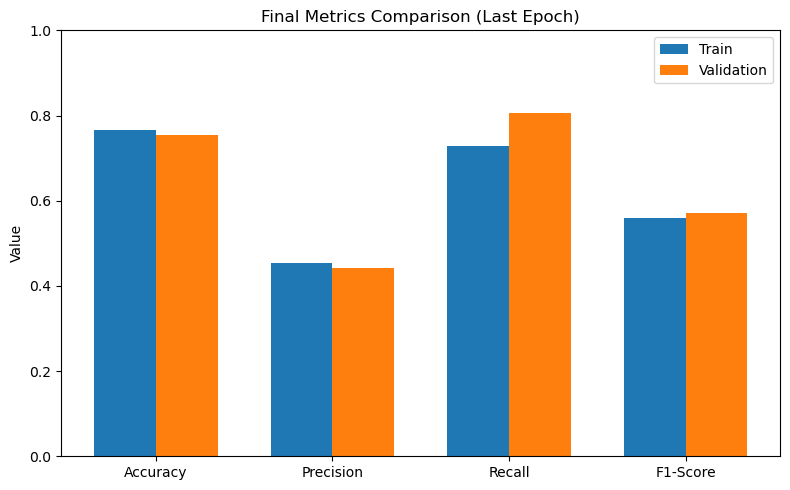

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Define metric names and their final values for train vs. validation
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
train_values = [
    final_train_accuracy,
    final_train_precision,
    final_train_recall,
    final_train_f1
]
val_values = [
    final_val_accuracy,
    final_val_precision,
    final_val_recall,
    final_val_f1
]

# Create a grouped bar chart
x = np.arange(len(metrics))  # [0, 1, 2, 3]
width = 0.35                 # The width of each bar

plt.figure(figsize=(8, 5))

# Plot training metrics
plt.bar(x - width/2, train_values, width, label='Train')

# Plot validation metrics
plt.bar(x + width/2, val_values, width, label='Validation')

# Add metric labels to the x-axis
plt.xticks(x, metrics)
plt.ylim([0, 1])  # Since metrics are typically between 0 and 1
plt.ylabel("Value")
plt.title("Final Metrics Comparison (Last Epoch)")
plt.legend()

plt.tight_layout()
plt.show()
